# El ciclo económico en Costa Rica

Este cuaderno lee datos del Banco Central de Costa Rica que han sido previamente almacenados en el archivo de Excel **Datos-business-cycle.xlsx** y aplica el filtro de Hodrick Prescott para analizar los ciclos.

*Randall Romero-Aguilar, 2017*

Empezamos importando algunos paquetes que serán útiles para este trabajo: 
* numpy: importamos la función log
* pandas: para manejar las bases de datos
* statsmodels: importamos dos funciones, una para aplicar el filtro, otra para desestacionalizar series
* seaborn: para que los gráficos sean más elegantes (opcional)

Finalmente, la indicacion __%matplotlib inline__ es para que los gráficos aparezcan en este mismo archivo (en vez de una ventana emergente).

In [1]:
import pandas as pd
from numpy import log
from statsmodels.tsa.filters.hp_filter import hpfilter
from statsmodels.tsa.seasonal import seasonal_decompose

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

En lo que sigue, se asume que los datos han sido previamente guardados en el archivo de Excel **Datos-business-cycle.xlsx**, ubicado en la misma carpeta que este cuaderno de Jupyter. Los datos se guardaron tal como fueron bajados desde el sitio web del BCCR. A los datos **no** se les aplicó ninguna transformación en Excel, únicamente se le cambió nombre a cada hoja de cálculo para que hiciera referencia al número de cuadro que se está utilizando.

## Datos de cuentas nacionales

Los datos están en la hoja *chart1677*, corresponden a
* Producto Interno Bruto Trimestral y Gasto a precios constantes
* Tendencia ciclo --- 1991 = 100
* http://indicadoreseconomicos.bccr.fi.cr/indicadoreseconomicos/Cuadros/frmVerCatCuadro.aspx?CodCuadro=1677

Ahora leemos los datos usando la función __read_excel__ de pandas. La opción *skiprows=4* indica que deben ignorarse las primeras 4 líneas de la hoja de excel; *index_col=0* le indica a pandas que la primera columna tiene nombres (no datos). La *.T* al final transpone los datos.

In [2]:
ctasnac = pd.read_excel('Datos-business-cycle.xlsx',sheetname='chart1677',skiprows=4,index_col=0).T

En el archivo original, los nombres de las series tienen muchos espacios en blanco. Para removerlos, aplicamos el método *.strip()* a los nombres originales. Luego sobreescribimos el nombre de las series cambiando la propiedad *.columns*.

In [3]:
ctasnac.columns = [name.strip() for name in ctasnac.columns]

Seleccionamos las tres columnas de interés, y les cambiamos el nombre a las series a 'PIB', 'C', 'I'.

In [4]:
ctasnac = ctasnac[['PRODUCTO INTERNO BRUTO', 'Gasto de consumo final de los hogares', 'Formación bruta de capital fijo']]
ctasnac.columns = ['PIB', 'C', 'I']

Indexamos los datos con la función de pandas **date_range**, indicando que el primer dato es de 1991q1, y que la serie es trimestral.

In [5]:
ctasnac.index = pd.date_range('1991q1', periods=ctasnac.shape[0],freq='Q')

Finalmente, aplicamos el filtro Hodrick-Prescott al **logaritmo** de los datos, y graficamos los resultados.

In [6]:
ctasnac_ciclo, ctasnac_tendencia = hpfilter(log(ctasnac), 1600)
ctasnac_ciclo.plot()

## Precios
Los datos están en la hoja *chart2732*, corresponden a 
* Índice de precios al consumidor (IPC)
* Junio 2015=100 --- Niveles y variaciones
* http://indicadoreseconomicos.bccr.fi.cr/indicadoreseconomicos/Cuadros/frmVerCatCuadro.aspx?CodCuadro=2732&FecInicial=1991/01/01

Al leer los datos de Excel, inmediatamente seleccionamos únicamente la serie 'Nivel', la cual renombramos como 'IPC'.

In [7]:
precios = pd.read_excel('Datos-business-cycle.xlsx',sheetname='chart2732',skiprows=4,index_col=0)[['Nivel']]
precios.columns = ['IPC']

Los datos originales son mensuales, por ello los indizamos como tales. Para poder compararlos con los datos de cuentas nacionales, los convertimos a datos trimestrales usando el método *.resample('Q')*, indicando que queremos el promedio de los tres meses correspondientes con *.mean()*.

In [8]:
precios.index = pd.date_range('1991-01', periods=precios.shape[0],freq='m')
precios = precios.resample('Q').mean()

Finalmente, aplicamos el filtro de HP.

In [9]:
precios_ciclo, precios_tendencia = hpfilter(log(precios), 1600)
precios_ciclo.plot()

## Dinero

Los datos están en la hoja *chart125*, corresponden a
* Medio circulante (M1) medido a nivel del sistema bancario
* Saldos a fin de mes en millones de colones
* http://indicadoreseconomicos.bccr.fi.cr/indicadoreseconomicos/Cuadros/frmVerCatCuadro.aspx?CodCuadro=125&FecInicial=1991/01/01

Leemos los datos y los graficamos:


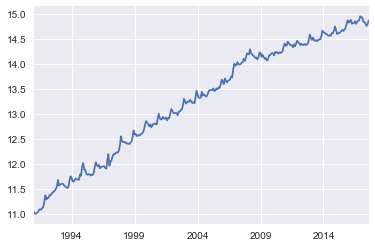

In [10]:
dinero = pd.read_excel('Datos-business-cycle.xlsx',sheetname='chart125',skiprows=4,index_col=0)
dinero = dinero.stack()
dinero.name = 'M1'
dinero.index = pd.date_range('1991-01', periods=dinero.shape[0],freq='m')
log(dinero).plot()

La serie del **M1** tiene un fuerte componente estacional. Por ejemplo, los diciembres la cantidad de dinero aumenta considerablemente debido al pago de aguinaldos. Esto lo podemos cuantificar con la función **seasonal_decompose**, con la versión multiplicativa. En el gráfico se muestra que típicamente el M1 es 12.5% superior en diciembre respecto a la media del año.

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\filters\filtertools.py:28: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return np.r_[[np.nan] * head, x, [np.nan] * tail]


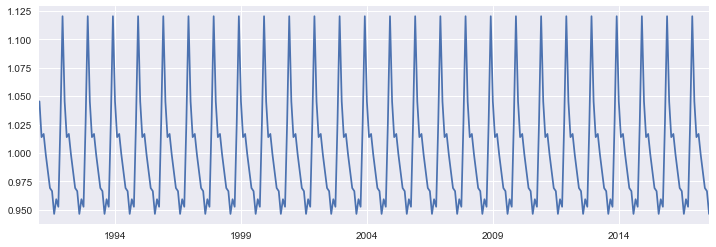

In [11]:
seasonal_decompose(dinero,'mult').seasonal.plot(figsize=[12,4])

Aunque la serie del **M1** que necesitamos es la trimestral, es de esperar que su fuerte componente estacional también se refleje en la serie trimestral. Por ello, cuantificamos de nuevo este componentes con la función **seasonal_decompose**y guardamos el componente __.seasonal__ como *m1_seasonal*.

Para eliminar el componente estacional de los datos, dividimos los datos originales entre *m1_seasonal*. Hecho esto, le aplicamos el filtro HP al logartimo de las serie.


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\filters\filtertools.py:28: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return np.r_[[np.nan] * head, x, [np.nan] * tail]


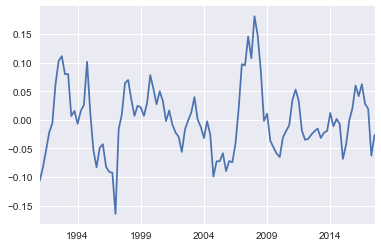

In [12]:
dinero = dinero.resample('Q').mean()
m1_seasonal = seasonal_decompose(dinero,'mult').seasonal
dinero /= m1_seasonal

dinero_ciclo, dinero_tendencia = hpfilter(log(dinero), 1600)
dinero_ciclo.plot()


## Empleo

Los datos están en la hoja  *chart1914*, que corresponde a
* Población ocupada en el empleo principal según posición en el empleo
* Número de personas por trimestre
* http://indicadoreseconomicos.bccr.fi.cr/indicadoreseconomicos/Cuadros/frmVerCatCuadro.aspx?CodCuadro=1914

Finalmente, leemos los datos de empleo, los cuales transponemos para que las columnas correspondan a series y las filas a trimestres. Utilizamos únicamente la serie 'Asalariado', la cual renombramos como 'N'.

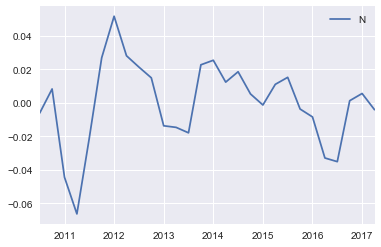

In [13]:
empleo = pd.read_excel('Datos-business-cycle.xlsx',sheetname='chart1914',skiprows=4,index_col=0).T
empleo.index = pd.date_range('2010q3', periods=empleo.shape[0],freq='Q')
empleo = empleo[['Asalariado']]
empleo.columns = ['N']

empleo_ciclo, empleo_tendencia = hpfilter(log(empleo))
empleo_ciclo.plot()


## Correlaciones de los ciclos 

Juntamos todos los datos de los ciclos en una misma base de datos

In [14]:
datos = pd.concat([ctasnac_ciclo, precios_ciclo, dinero_ciclo, empleo_ciclo], axis=1)

Las correlaciones de estas series con el PIB puede calcularse usando el método __.corrwith__.

In [15]:
datos.corrwith(datos['PIB'])

PIB    1.000000
C      0.748236
I      0.686924
IPC   -0.254874
M1     0.664083
N      0.525185
dtype: float64

Estas correlaciones las ilustramos graficando cada serie contra el PIB. En cada gráfico mostramos además una regresión lineal entre la serie respectiva y el PIB.

In [16]:
fig, ax = plt.subplots(nrows=5, ncols=1,sharex=True,figsize=[6,30],)
for var, eje in zip(datos.columns[1:], ax):
    sns.regplot(x="PIB", y=var, data=datos,ax=eje)

Acá calculamos de nuevo las correlaciones, pero esta vez con el rezago, el valor contemporaneo, y el valor adelantado del PIB

In [17]:
correlaciones = pd.DataFrame([datos.corrwith(datos['PIB'].shift(t)) for t in [-1,0,1]])
correlaciones.index = ['t-1', 't', 't+1']
correlaciones.T

t-1         t       t+1
PIB  0.931315  1.000000  0.931315
C    0.726598  0.748236  0.698410
I    0.650257  0.686924  0.647775
IPC -0.280403 -0.254874 -0.237753
M1   0.620570  0.664083  0.643834
N    0.349455  0.525185  0.505711

## Volatilidad relativa de los ciclos 

Finalmente, calculamos la volatilidad de cada serie, relativa a la del PIB.

In [18]:
volatilidad = 100 * datos.std() / datos['PIB'].std()
volatilidad

PIB    100.000000
C       59.637276
I      287.567259
IPC     95.581168
M1     289.570549
N      122.093110
dtype: float64

Puede verse que el consumo es menos volátil que el PIB, mientras que la inversión y el dinero son mucho más volátiles.